In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch as torch
import pywt
from scipy.signal import welch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch.optim as optim
from xgboost import XGBClassifier

In [2]:
import numpy as np
import pywt
from scipy.signal import welch
import os
import pandas as pd
import torch
from torch.utils.data import Dataset

class EEGUtil:
    @staticmethod
    def load_data(file_path, column_name='spike hz'):
        """Load EEG data from a CSV file."""
        data = pd.read_csv(file_path)
        signal = data[column_name].values
        return signal

    @staticmethod
    def padding(signal, target_length, mode="constant", constant_value=-1):
        """Pad or truncate signal to the target length with various strategies."""
        signal = np.array(signal)
        current_length = len(signal)
        
        if current_length >= target_length:
            return signal[:target_length]

        padding_size = target_length - current_length

        if mode == "constant":
            return np.pad(signal, (0, padding_size), 'constant', constant_values=constant_value)
        elif mode == "reflect":
            return np.pad(signal, (0, padding_size), 'reflect')
        elif mode == "cyclic":
            return np.pad(signal, (0, padding_size), 'wrap')
        elif mode == "edge":
            return np.pad(signal, (0, padding_size), 'edge')
        elif mode == "random":
            random_padding = np.random.uniform(low=np.min(signal), high=np.max(signal), size=padding_size)
            return np.concatenate((signal, random_padding))
        else:
            raise ValueError(f"Unsupported padding mode: {mode}")

    @staticmethod
    def wavelet_transform(signal):
        """Perform Wavelet Transform and extract features."""
        coeffs = pywt.wavedec(signal, 'db4', level=5)
        features = []
        for i in range(1, len(coeffs)):
            features.extend([np.mean(coeffs[i]), np.std(coeffs[i])])
        return np.array(features)

    @staticmethod
    def psd_transform(signal, fs=0.2, nperseg=128):
        """Perform Power Spectral Density analysis and extract features."""
        _, psd = welch(signal, fs=fs, nperseg=nperseg)
        return psd

In [3]:
import numpy as np
import os
import pandas as pd
import torch
from torch.utils.data import Dataset

class EEGDataset(Dataset):
    def __init__(self, data_folder, outcome_file=None, ssd_file=None,target_length=600, strategy='padding', 
                 padding_mode="constant", use_labels=True, augment=False,num_good=10,num_bad=2):
        """
        EEG 信号数据集，支持数据增强（随机填充）。

        参数：
        - data_folder: EEG 数据文件夹路径
        - outcome_file: CSV 文件，包含患者 ID 和 outcome（可选）
        - target_length: 目标填充长度
        - strategy: 预处理策略 ('padding', 'wavelet', 'psd')
        - padding_mode: 填充模式 ('constant', 'reflect', ...)
        - use_labels: 是否使用标签
        - augment: 是否启用数据增强（随机填充不同长度）
        """
        
        self.use_labels = use_labels
        self.data_folder = data_folder
        self.target_length = target_length
        self.strategy = strategy
        self.padding_mode = padding_mode
        self.augment = augment  # 是否启用数据增强
        
        self.num_good = num_good
        self.num_bad = num_bad

        self.file_list = [f for f in os.listdir(data_folder) if f.endswith('.csv')]
       
        # 读取 `rosc_sec` 开始时间
        ssd_df = pd.read_csv(ssd_file)
        # 提取 `pat_ID`
        ssd_df["pat_ID"] = ssd_df["fn"].str.extract(r"(ICARE_\d+)")
        # **取每个 `pat_ID` 最小的 `rosc_sec`**
        self.rosc_dict = ssd_df.groupby("pat_ID")["rosc_sec"].min().to_dict()
        
        # 加载标签
        self.outcome_dict = {}
        if use_labels and outcome_file:
            self.outcome_data = pd.read_csv(outcome_file)
            self.outcome_dict = self.outcome_data.set_index('pat_ID')['outcome'].to_dict()
            self.file_list = [f for f in self.file_list if f.split('.')[0] in self.outcome_dict]
        
        self.valid_files = []
        # **筛选符合 16h-68h 规则的 EEG 数据**
        for f in self.file_list:
            pat_id = f.split('.')[0]

            if pat_id in self.rosc_dict:
                file_path = os.path.join(self.data_folder, f)
                signal = EEGUtil.load_data(file_path, column_name='spike hz')  # 读取 EEG 信号
                rosc_sec = float(self.rosc_dict[pat_id])  # 确保 `rosc_sec` 是 `float`

                # **EEG 记录的时间范围**
                start_time = rosc_sec
                end_time = start_time + len(signal) * 300  # 每个点是 5min（=300 秒）
                # **如果数据完全不在 16h-68h 观察期内，跳过**
                if end_time < 16 * 3600 or start_time > 68 * 3600:
                    #print(f"❌ Skipping {pat_id}: EEG data is out of 16h-68h range ({start_time/3600:.1f}h - {end_time/3600:.1f}h)")
                    continue  
                    
                # **对齐到 16h-68h**
                aligned_signal = self.align_signal(signal, rosc_sec)
                self.valid_files.append((f, aligned_signal))
        
        print(f"✅ Loaded {len(self.valid_files)} valid EEG files (filtered from {len(self.file_list)} total)")
        
        # **统计 Good / Bad Outcome 样本数**
        self.good_outcome_count = sum(1 for f, _ in self.valid_files if self.get_label(f.split('.')[0]) == 1)
        self.bad_outcome_count = len(self.valid_files) - self.good_outcome_count

        print(f"Good Outcome: {self.good_outcome_count}, Bad Outcome: {self.bad_outcome_count}")

        # **数据增强：扩展索引**
        self.expanded_indices = []
        for idx, (filename, signal) in enumerate(self.valid_files):
            patient_id = filename.split('.')[0]
            label = self.get_label(patient_id) if self.use_labels else -1

            if self.augment:
                if self.use_labels:
                    # Good Outcome 10倍，Bad Outcome 2倍
                    if label == 1:
                        repeat_times = self.num_good
                    else:
                        repeat_times = self.num_bad
                else:
                    repeat_times = 2  # 无标签数据增强
            else:
                repeat_times = 1  

            for _ in range(repeat_times):
                self.expanded_indices.append((idx, label))  # ✅ 存储索引 & 标签
       
        #print("✅ Debug: expanded_indices sample:", self.expanded_indices[:10])  # 只打印前 10 个

    
    def __len__(self):
        #print(f"📏 Dataset __len__: {len(self.expanded_indices)}")  # 确保 `expanded_indices` 长度正确
        return len(self.expanded_indices)  # ✅ 这里必须返回 **数据增强后的样本数量**

    def __getitem__(self, idx):
        original_idx, label = self.expanded_indices[idx]
        filename, signal = self.valid_files[original_idx]  # 直接获取 **已经对齐的** 信号
        patient_id = filename.split('.')[0]

        # 获取标签
        label = -1
        if self.use_labels:
            label = self.get_label(patient_id)

        # 进行数据增强（每次都不同）
        if self.augment:
            augmented_signal = self.augment_signal(signal)  # ✅ 直接对 **已经对齐的信号** 进行数据增强
        else:
            augmented_signal = signal  # ✅ 直接使用对齐后的信号
        return torch.tensor(augmented_signal, dtype=torch.float32).unsqueeze(0), label
    
    def align_signal(self, signal, rosc_sec):
        """对齐 EEG 数据到 16h-68h 观察期"""

        target_length = self.target_length  # 52小时的 `5min` 窗口数（624）
        total_signal_length = len(signal)  # EEG 记录的总长度
        rosc_sec = float(rosc_sec)  # ✅ 确保 `rosc_sec` 是 `float`
        #print(f"🔍 Processing patient: rosc_sec={rosc_sec}, total_signal_length={total_signal_length}")

        # **计算 `16h` 在 EEG 记录中的起点**
        start_sec = (16 * 3600) - rosc_sec  
        if start_sec < 0:
            pad_size = abs(start_sec) / 300  # 计算需要填充的窗口数
            start_index = 0  # 从 EEG 记录最开始取数据
        else:
            pad_size = 0  # 不需要填充
            start_index = int(start_sec // 300)  # ✅ 强制转换为整数

        # **计算 `68h` 终点索引**
        end_index = int(min(start_index + target_length, total_signal_length))  # ✅ 强制转换为整数

        # **提取 `16h-68h` 观察期 EEG 数据**
        aligned_signal = signal[start_index:end_index]

        # **前面 `padding`（如果 `rosc_sec > 16h`）**
        if pad_size > 0:
            aligned_signal = EEGDataset.pad_signal(aligned_signal, target_length, self.padding_mode, padding_position="pre")

        # **后面 `padding`（如果数据不足 52h）**
        aligned_signal = EEGDataset.pad_signal(aligned_signal, target_length, self.padding_mode, padding_position="post")

        #print(f"✅ Aligned signal length: {len(aligned_signal)}")
        return aligned_signal
    
    def pad_signal(signal, target_length, mode="constant", constant_value=-1, padding_position="post"):
        """对 EEG 信号进行填充，以确保长度达到 `target_length`。

        参数：
        - signal: 原始 EEG 信号 (numpy array)
        - target_length: 目标长度 (52h = 624 个 `5min` 窗口)
        - mode: 填充模式：
            - `constant`: 固定值填充 (`constant_value`)
            - `reflect`: 镜像填充
            - `cyclic`: 循环填充
            - `edge`: 边缘填充
            - `random`: 在 [min, max] 之间随机填充
        - padding_position: `"pre"` (填充到前面) 或 `"post"` (填充到后面)

        返回：
        - 填充后的 EEG 信号 (numpy array)
        """

        current_length = len(signal)
        if current_length >= target_length:
            return signal[:target_length]  # 如果已经足够长，直接截断

        padding_size = target_length - current_length  # 需要填充的数量

        if mode == "constant":
            pad_values = np.full(padding_size, constant_value)
        elif mode == "reflect":
            pad_values = np.pad(signal, (0, padding_size), mode='reflect')[-padding_size:]
        elif mode == "cyclic":
            pad_values = np.pad(signal, (0, padding_size), mode='wrap')[-padding_size:]
        elif mode == "edge":
            pad_values = np.pad(signal, (0, padding_size), mode='edge')[-padding_size:]
        elif mode == "random":
            pad_values = np.random.uniform(low=np.min(signal), high=np.max(signal), size=padding_size)
        else:
            raise ValueError(f"Unsupported padding mode: {mode}")

        # **前面填充 or 后面填充**
        if padding_position == "pre":
            padded_signal = np.concatenate((pad_values, signal))  # **填充在前面**
        else:
            padded_signal = np.concatenate((signal, pad_values))  # **填充在后面**

        return padded_signal[:target_length]  # **确保最终长度严格等于 `target_length`**
   
    def augment_signal(self, signal):
        """数据增强：基于 16h-68h 观察期，通过前移/后移 EEG 数据实现"""

        target_length = self.target_length  # 52 小时的 `5min` 窗口数（624）
        current_length = len(signal)  # 当前 EEG 记录的长度

        # **增强前检查是否已对齐到 16h-68h**
        if current_length != target_length:
            raise ValueError(f"数据增强前，信号长度应为 {target_length}，但收到 {current_length}")

        # **增强策略 1: 允许 ±60min 内的随机时间偏移**
        max_shift = 12  # `5min` 窗口，60 分钟 = 12 个点
        shift = np.random.randint(-max_shift, max_shift + 1)  # 在 [-6, 6] 之间随机偏移

        # **计算新起点，并确保不越界**
        start_index = max(0, min(current_length - target_length, shift))
        end_index = min(start_index + target_length, current_length)

        # **裁剪 EEG 数据**
        augmented_signal = signal[start_index:end_index]

        # **增强策略 2: 根据 `shift` 方向决定填充位置**
        if len(augmented_signal) < target_length:
            padding_size = target_length - len(augmented_signal)

            if shift > 0:
                # **右移：前面填充**
                augmented_signal = np.concatenate((self.pad_signal([], padding_size, self.padding_mode), augmented_signal))
            elif shift < 0:
                # **左移：后面填充**
                augmented_signal = np.concatenate((augmented_signal, self.pad_signal([], padding_size, self.padding_mode)))
            else:
                # **shift == 0，无需填充**
                augmented_signal = self.pad_signal(augmented_signal, target_length, self.padding_mode)

        return augmented_signal

    def get_label(self, patient_id):
        """确保 label 只返回 0 或 1，避免返回 -1"""
        if patient_id in self.outcome_dict:
            return 1 if self.outcome_dict[patient_id] == 'Good Outcome' else 0
        else:
            print(f"⚠️ Warning: {patient_id} has no label, but was still included!")
            return None  # ✅ 这里改成 None，而不是 -1
    
    def compare_data_augmentation(self):
        """Compare the number of samples before and after data augmentation."""
        original_count = len(self.valid_files)  # 只统计符合16h条件的文件
        augmented_count = len(self.expanded_indices)  # 统计扩增后的样本数量

        print(f"Data count before augmentation: {original_count}")
        print(f"Data count after augmentation: {augmented_count}")
        print(f"Augmentation ratio: {augmented_count / original_count:.2f}x")

        if self.use_labels:
            # 统计 Good Outcome 和 Bad Outcome 在原始数据中的数量（基于 filtered_files）
            good_outcome_original = sum(1 for f, _ in self.valid_files if self.get_label(f.split('.')[0]) == 1)
            bad_outcome_original = original_count - good_outcome_original  # 剩下的就是 Bad Outcome

            # 统计 Good Outcome 和 Bad Outcome 在扩增后的数量
            good_outcome_augmented = sum(
            1 for (idx, _) in self.expanded_indices  # ✅ 只取 idx，不取 label
            if self.get_label(self.valid_files[idx][0].split('.')[0]) == 1
            )
            bad_outcome_augmented = augmented_count - good_outcome_augmented  # 剩下的就是 Bad Outcome

            print(f"Good Outcome before augmentation: {good_outcome_original}, after augmentation: {good_outcome_augmented}")
            print(f"Bad Outcome before augmentation: {bad_outcome_original}, after augmentation: {bad_outcome_augmented}")

        return original_count, augmented_count

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

# 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 超参数
latent_dim = 128  # 潜在空间维度
num_classes = 2   # 分类任务类别（0/1）
seq_length = (68 - 16) * 12  # EEG 时间序列长度
batch_size = 32
epochs = 100
alpha = 1e-6  # KL 损失权重

# 1️⃣ **编码器 (Encoder)**
class EEG2VecEncoder(nn.Module):
    def __init__(self, input_dim=seq_length, latent_dim=latent_dim, num_classes=num_classes):
        super(EEG2VecEncoder, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim + num_classes, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, latent_dim * 2)  # 输出 μ 和 log(σ^2)
        )
        self.classifier = nn.Linear(256, num_classes)  # 分类器

    def forward(self, x, y):
        y_onehot = F.one_hot(y, num_classes=num_classes).float()
        x = torch.cat([x, y_onehot], dim=1)  # 条件信息拼接
        latent_params = self.fc(x)
        mu, log_var = torch.chunk(latent_params, 2, dim=1)
        y_pred = self.classifier(x)
        return mu, log_var, y_pred  # 输出均值、方差和分类预测

# 2️⃣ **分类器 (Classifier)**
class EEG2VecClassifier(nn.Module):
    def __init__(self, latent_dim=latent_dim, num_classes=num_classes):
        super(EEG2VecClassifier, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes),
            nn.Softmax(dim=1)
        )

    def forward(self, z):
        return self.fc(z)

# 3️⃣ **解码器 (Decoder)**
class EEG2VecDecoder(nn.Module):
    def __init__(self, latent_dim=latent_dim, output_dim=seq_length, num_classes=num_classes):
        super(EEG2VecDecoder, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(latent_dim + num_classes, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, output_dim),
            nn.Tanh()
        )

    def forward(self, z, y):
        y_onehot = F.one_hot(y, num_classes=num_classes).float()
        z = torch.cat([z, y_onehot], dim=1)
        x_recon = self.fc(z)
        return x_recon.view(-1, seq_length)

# 4️⃣ **完整 CVAE 模型**
class EEG2Vec(nn.Module):
    def __init__(self, latent_dim=latent_dim, num_classes=num_classes):
        super(EEG2Vec, self).__init__()
        self.encoder = EEG2VecEncoder(latent_dim=latent_dim, num_classes=num_classes)
        self.classifier = EEG2VecClassifier(latent_dim=latent_dim, num_classes=num_classes)
        self.decoder = EEG2VecDecoder(latent_dim=latent_dim, num_classes=num_classes)

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x, y):
        mu, log_var, y_pred = self.encoder(x, y)
        z = self.reparameterize(mu, log_var)
        recon_x = self.decoder(z, y)
        return recon_x, mu, log_var, y_pred

In [5]:
# 5️⃣ **训练 CVAE**
def train_cvae(model, dataloader, optimizer, alpha=1e-6):
    model.train()
    total_loss, total_class_loss = 0, 0
    recon_criterion = nn.MSELoss()
    class_criterion = nn.CrossEntropyLoss()

    for data, labels in dataloader:
        data, labels = data.to(device), labels.to(device).long()
        optimizer.zero_grad()

        recon_x, mu, log_var, y_pred = model(data, labels)

        recon_loss = recon_criterion(recon_x, data)
        kl_loss = -0.5 * torch.mean(1 + log_var - mu.pow(2) - log_var.exp())
        class_loss = class_criterion(y_pred, labels)

        loss = recon_loss + alpha * kl_loss + class_loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * data.size(0)
        total_class_loss += class_loss.item() * data.size(0)

    return total_loss / len(dataloader.dataset), total_class_loss / len(dataloader.dataset)

# 6️⃣ **测试 CVAE**
def test_cvae(model, dataloader):
    model.eval()
    total_loss, total_class_loss, correct, total = 0, 0, 0, 0
    recon_criterion = nn.MSELoss()
    class_criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for data, labels in dataloader:
            data, labels = data.to(device), labels.to(device).long()
            recon_x, mu, log_var, y_pred = model(data, labels)

            recon_loss = recon_criterion(recon_x, data)
            kl_loss = -0.5 * torch.mean(1 + log_var - mu.pow(2) - log_var.exp())
            class_loss = class_criterion(y_pred, labels)

            loss = recon_loss + alpha * kl_loss + class_loss

            total_loss += loss.item() * data.size(0)
            total_class_loss += class_loss.item() * data.size(0)

            predictions = y_pred.argmax(dim=1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    return total_loss / len(dataloader.dataset), total_class_loss / len(dataloader.dataset), accuracy

In [6]:
latent_dim = 10  # 潛在空間的維度
initial_channels = 128  # CNN 的初始通道數
seq_length =(68 - 16) * 12 # 52小时的 5min 窗口数（624）
batch_size = 32
epochs = 100
alpha = 1e-6  # KL 損失的權重
patience = 10  # 定义在多少个 epoch 不改善后停止训练
padding_method='constant'# 使用反射填充
is_augment=True

# 定義數據文件夾路徑
data_folder = '5min_smoothed_data/'  # 替換為你實際的數據文件夾路徑
valid_outcome_data = 'valid_patients_outcome.csv'
ssd_file='files_art_ssd_fts_predictions.csv'

# 创建 EEG 数据集（训练 VAE 时不使用标签）
eeg_dataset = EEGDataset(
    data_folder='5min_smoothed_data/',
    outcome_file='valid_patients_outcome.csv',
    ssd_file=ssd_file,
    target_length=seq_length,
    strategy='padding',
    padding_mode=padding_method,
    use_labels=True,  # 使用标签以计算类别增强
    augment=is_augment,      # 启用数据增强
    num_good=1,
    num_bad=1
)


# 7️⃣ **数据加载**
train_loader = DataLoader(eeg_dataset, batch_size=batch_size, shuffle=True)

# 8️⃣ **初始化 CVAE**
eeg2vec = EEG2Vec().to(device)
optimizer = torch.optim.Adam(eeg2vec.parameters(), lr=1e-3)

# 9️⃣ **训练 CVAE**
train_losses, train_class_losses = [], []
for epoch in range(epochs):
    train_loss, train_class_loss = train_cvae(eeg2vec, train_loader, optimizer)
    train_losses.append(train_loss)
    train_class_losses.append(train_class_loss)
    print(f"Epoch {epoch+1}: Loss = {train_loss:.4f}, Class Loss = {train_class_loss:.4f}")

# 1️⃣0️⃣ **可视化**
plt.plot(train_losses, label="Reconstruction Loss")
plt.plot(train_class_losses, label="Classification Loss")
plt.legend()
plt.show()

✅ Loaded 266 valid EEG files (filtered from 298 total)
Good Outcome: 43, Bad Outcome: 223


RuntimeError: Tensors must have same number of dimensions: got 3 and 2

In [24]:
class CNNEncoder(nn.Module):
    def __init__(self, latent_dim, num_classes=2):
        super(CNNEncoder, self).__init__()
        self.latent_dim = latent_dim
        self.num_classes = num_classes

        self.conv_layers = nn.Sequential(
            nn.Conv1d(1, 128, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.Conv1d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.Conv1d(64, 32, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU()
        )

        self.fc_mean = nn.Linear(32 * seq_length + num_classes, latent_dim)
        self.fc_logvar = nn.Linear(32 * seq_length + num_classes, latent_dim)
        self.fc_classifier = nn.Linear(32 * seq_length + num_classes, num_classes)  # 分类器头部

    def forward(self, x, y):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)

        y_onehot = F.one_hot(y, num_classes=self.num_classes).float()
        x = torch.cat([x, y_onehot], dim=1)  

        mean = self.fc_mean(x)
        logvar = self.fc_logvar(x)
        y_pred = self.fc_classifier(x)  # 分类器输出
        
        return mean, logvar, y_pred

class CNNDecoder(nn.Module):
    def __init__(self, latent_dim, num_classes=2):
        super(CNNDecoder, self).__init__()
        self.latent_dim = latent_dim
        self.num_classes = num_classes

        self.fc = nn.Linear(latent_dim + num_classes, 32 * seq_length)

        self.deconv_layers = nn.Sequential(
            nn.ConvTranspose1d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.ConvTranspose1d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.ConvTranspose1d(128, 1, kernel_size=3, stride=1, padding=1),
        )

    def forward(self, z, y):
        # **转换 y 为 one-hot**
        y_onehot = F.one_hot(y, num_classes=self.num_classes).float()
        z = torch.cat([z, y_onehot], dim=1)

        x = self.fc(z)
        x = x.view(x.size(0), 32, seq_length)
        x = self.deconv_layers(x)
        return x
    
class CVAE(nn.Module):
    def __init__(self, latent_dim, num_classes=2):
        super(CVAE, self).__init__()
        self.encoder = CNNEncoder(latent_dim, num_classes)
        self.decoder = CNNDecoder(latent_dim, num_classes)

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std

    def forward(self, x, y):
        mean, logvar, y_pred = self.encoder(x, y)
        z = self.reparameterize(mean, logvar)
        reconstruction = self.decoder(z, y)
        return reconstruction, mean, logvar, y_pred
    
# 4️⃣ **定义训练函数**
def train_cvae(model, dataloader, optimizer, alpha=1e-6):
    model.train()
    total_loss, total_class_loss = 0, 0
    classification_criterion = nn.CrossEntropyLoss()  # 分类损失

    for data, labels in dataloader:
        data, labels = data.to(device), labels.to(device).long()
        optimizer.zero_grad()

        reconstruction, mean, logvar, y_pred = model(data, labels)

        # **重构损失**
        recon_loss = criterion(reconstruction, data)
        # **KL 散度损失**
        kl_loss = -0.5 * torch.mean(1 + logvar - mean.pow(2) - logvar.exp())
        # **分类损失**
        class_loss = classification_criterion(y_pred, labels)

        loss = recon_loss + alpha * kl_loss + class_loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * data.size(0)
        total_class_loss += class_loss.item() * data.size(0)

    return total_loss / len(dataloader.dataset), total_class_loss / len(dataloader.dataset)

# 5️⃣ **定义测试函数**
def test_cvae(model, dataloader):
    model.eval()
    total_loss, total_class_loss, correct, total = 0, 0, 0, 0
    classification_criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for data, labels in dataloader:
            data, labels = data.to(device), labels.to(device).long()
            reconstruction, mean, logvar, y_pred = model(data, labels)

            # **计算损失**
            recon_loss = criterion(reconstruction, data)
            kl_loss = -0.5 * torch.mean(1 + logvar - mean.pow(2) - logvar.exp())
            class_loss = classification_criterion(y_pred, labels)

            loss = recon_loss + alpha * kl_loss + class_loss

            total_loss += loss.item() * data.size(0)
            total_class_loss += class_loss.item() * data.size(0)

            # **计算分类准确率**
            predictions = y_pred.argmax(dim=1)  # 取最大概率类别
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    return total_loss / len(dataloader.dataset), total_class_loss / len(dataloader.dataset), accuracy

In [30]:
latent_dim = 10  # 潛在空間的維度
initial_channels = 128  # CNN 的初始通道數
seq_length =(68 - 16) * 12 # 52小时的 5min 窗口数（624）
batch_size = 32
epochs = 100
alpha = 1e-6  # KL 損失的權重
patience = 10  # 定义在多少个 epoch 不改善后停止训练
padding_method='constant'# 使用反射填充
is_augment=True

# 定義數據文件夾路徑
data_folder = '5min_smoothed_data/'  # 替換為你實際的數據文件夾路徑
valid_outcome_data = 'valid_patients_outcome.csv'
ssd_file='files_art_ssd_fts_predictions.csv'

# 创建 EEG 数据集（训练 VAE 时不使用标签）
eeg_dataset = EEGDataset(
    data_folder='5min_smoothed_data/',
    outcome_file='valid_patients_outcome.csv',
    ssd_file=ssd_file,
    target_length=seq_length,
    strategy='padding',
    padding_mode=padding_method,
    use_labels=True,  # 使用标签以计算类别增强
    augment=is_augment,      # 启用数据增强
    num_good=1,
    num_bad=1
)


✅ Loaded 266 valid EEG files (filtered from 298 total)
Good Outcome: 43, Bad Outcome: 223


Epoch 1: Train Loss = 1.9172, Class Loss = 0.4974, Test Loss = 1.5882, Test Class Loss = 0.4381, Test Acc = 0.8333
Epoch 2: Train Loss = 1.5705, Class Loss = 0.4140, Test Loss = 1.4460, Test Class Loss = 0.4371, Test Acc = 0.8333
Epoch 3: Train Loss = 1.3886, Class Loss = 0.4192, Test Loss = 1.4242, Test Class Loss = 0.4616, Test Acc = 0.8333
Epoch 4: Train Loss = 1.2564, Class Loss = 0.3769, Test Loss = 1.3372, Test Class Loss = 0.4699, Test Acc = 0.8333
Epoch 5: Train Loss = 1.1607, Class Loss = 0.3820, Test Loss = 1.2523, Test Class Loss = 0.4626, Test Acc = 0.8333
Epoch 6: Train Loss = 1.0776, Class Loss = 0.4013, Test Loss = 1.1503, Test Class Loss = 0.4653, Test Acc = 0.8333
Epoch 7: Train Loss = 0.9211, Class Loss = 0.3544, Test Loss = 1.1212, Test Class Loss = 0.5972, Test Acc = 0.8333
Epoch 8: Train Loss = 0.8364, Class Loss = 0.4164, Test Loss = 0.8826, Test Class Loss = 0.5095, Test Acc = 0.7593
Epoch 9: Train Loss = 0.6882, Class Loss = 0.3546, Test Loss = 0.7747, Test Clas

Epoch 72: Train Loss = 0.0355, Class Loss = 0.0039, Test Loss = 1.5780, Test Class Loss = 1.4667, Test Acc = 0.7963
Epoch 73: Train Loss = 0.0336, Class Loss = 0.0033, Test Loss = 1.5558, Test Class Loss = 1.4441, Test Acc = 0.7963
Epoch 74: Train Loss = 0.0333, Class Loss = 0.0032, Test Loss = 1.5805, Test Class Loss = 1.4701, Test Acc = 0.7963
Epoch 75: Train Loss = 0.0323, Class Loss = 0.0028, Test Loss = 1.5855, Test Class Loss = 1.4756, Test Acc = 0.7963
Epoch 76: Train Loss = 0.0320, Class Loss = 0.0031, Test Loss = 1.5909, Test Class Loss = 1.4801, Test Acc = 0.8148
Epoch 77: Train Loss = 0.0317, Class Loss = 0.0026, Test Loss = 1.6211, Test Class Loss = 1.5123, Test Acc = 0.7963
Epoch 78: Train Loss = 0.0314, Class Loss = 0.0025, Test Loss = 1.6563, Test Class Loss = 1.5450, Test Acc = 0.7963
Epoch 79: Train Loss = 0.0299, Class Loss = 0.0023, Test Loss = 1.6554, Test Class Loss = 1.5455, Test Acc = 0.7963
Epoch 80: Train Loss = 0.0293, Class Loss = 0.0021, Test Loss = 1.6788, 

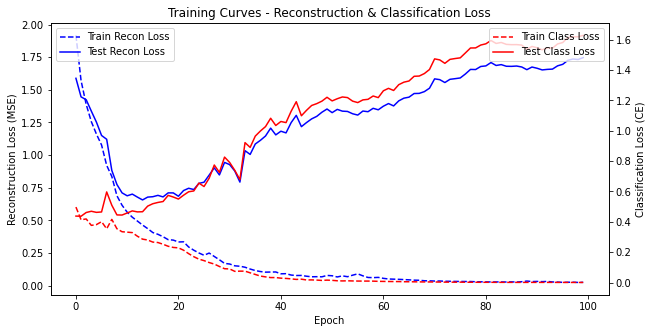

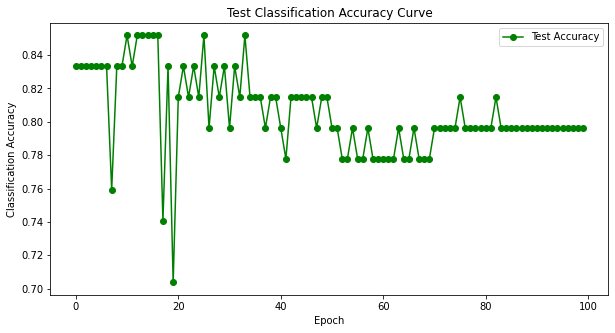

In [31]:
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt

# 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1️⃣ **划分 Train/Test 数据**
indices = list(range(len(eeg_dataset)))
train_idx, test_idx = train_test_split(indices, test_size=0.2, stratify=[eeg_dataset[i][1] for i in indices], random_state=42)

train_subset = Subset(eeg_dataset, train_idx)
test_subset = Subset(eeg_dataset, test_idx)

# 2️⃣ **创建 DataLoader**
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

# 3️⃣ **初始化 CVAE 模型**
cvae = CVAE(latent_dim=latent_dim).to(device)
optimizer = optim.Adam(cvae.parameters(), lr=1e-3)
criterion = nn.MSELoss()

import matplotlib.pyplot as plt

# 记录损失和准确率
train_losses, train_class_losses = [], []
test_losses, test_class_losses, test_accuracies = [], [],[]

for epoch in range(epochs):
    train_loss, train_class_loss = train_cvae(cvae, train_loader, optimizer)
    test_loss, test_class_loss, test_accuracy = test_cvae(cvae, test_loader)

    # **保存训练历史**
    train_losses.append(train_loss)
    train_class_losses.append(train_class_loss)
    test_losses.append(test_loss)
    test_class_losses.append(test_class_loss)
    test_accuracies.append(test_accuracy)

    print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Class Loss = {train_class_loss:.4f}, "
          f"Test Loss = {test_loss:.4f}, Test Class Loss = {test_class_loss:.4f}, Test Acc = {test_accuracy:.4f}")

# 训练完成后绘制曲线
fig, ax1 = plt.subplots(figsize=(10, 5))

# **重构损失曲线**
ax1.plot(train_losses, label="Train Recon Loss", color="blue", linestyle="--")
ax1.plot(test_losses, label="Test Recon Loss", color="blue")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Reconstruction Loss (MSE)")
ax1.legend(loc="upper left")

# **分类损失曲线**
ax2 = ax1.twinx()
ax2.plot(train_class_losses, label="Train Class Loss", color="red", linestyle="--")
ax2.plot(test_class_losses, label="Test Class Loss", color="red")
ax2.set_ylabel("Classification Loss (CE)")
ax2.legend(loc="upper right")

plt.title("Training Curves - Reconstruction & Classification Loss")
plt.show()

# **绘制分类准确率曲线**
plt.figure(figsize=(10, 5))
plt.plot(test_accuracies, label="Test Accuracy", color="green", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Classification Accuracy")
plt.title("Test Classification Accuracy Curve")
plt.legend()
plt.show()

In [32]:
from sklearn.metrics import classification_report, confusion_matrix

def evaluate_cvae_classification(model, dataloader):
    model.eval()
    all_labels, all_preds = [], []
    
    with torch.no_grad():
        for data, labels in dataloader:
            data, labels = data.to(device), labels.to(device).long()
            _, _, _, y_pred = model(data, labels)
            predictions = y_pred.argmax(dim=1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predictions.cpu().numpy())

    # **生成分类报告**
    print("\n✅ Classification Report:\n", classification_report(all_labels, all_preds))
    print("\n✅ Confusion Matrix:\n", confusion_matrix(all_labels, all_preds))

# **在测试集上评估分类表现**
evaluate_cvae_classification(cvae, test_loader)


✅ Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.96      0.89        45
           1       0.00      0.00      0.00         9

    accuracy                           0.80        54
   macro avg       0.41      0.48      0.44        54
weighted avg       0.69      0.80      0.74        54


✅ Confusion Matrix:
 [[43  2]
 [ 9  0]]


In [33]:
import numpy as np

def extract_latent_features(model, dataloader):
    model.eval()
    latent_features, labels = [], []

    with torch.no_grad():
        for data, target in dataloader:
            data, target = data.to(device), target.to(device).long()
            mean, _, _ = model.encoder(data, target)  # 提取 `均值` 作为潜在变量
            latent_features.append(mean.cpu().numpy())
            labels.extend(target.cpu().numpy())

    return np.vstack(latent_features), np.array(labels)

# 提取训练集 & 测试集的潜在特征
X_train, y_train = extract_latent_features(cvae, train_loader)
X_test, y_test = extract_latent_features(cvae, test_loader)

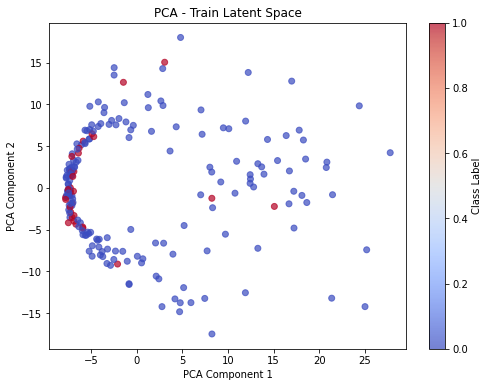

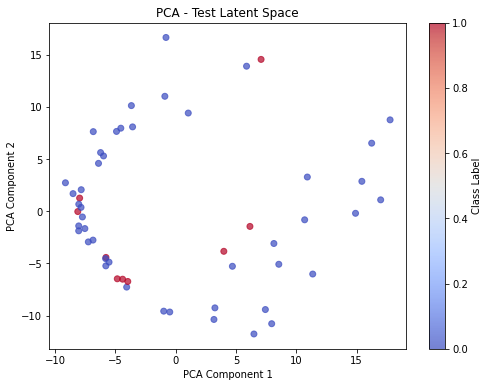

In [34]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def plot_latent_features(X, y, title="Latent Space Visualization"):
    pca = PCA(n_components=2)  # **降维到 2 维**
    X_pca = pca.fit_transform(X)

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap="coolwarm", alpha=0.7)
    plt.colorbar(scatter, label="Class Label")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.title(title)
    plt.show()

# **绘制训练集 & 测试集的潜在空间分布**
plot_latent_features(X_train, y_train, title="PCA - Train Latent Space")
plot_latent_features(X_test, y_test, title="PCA - Test Latent Space")

# 创建 EEG 数据集（训练 VAE 时不使用标签）
"""
eeg_dataset = EEGDataset(
    data_folder='5min_smoothed_data/',
    outcome_file='valid_patients_outcome.csv',
    ssd_file=ssd_file,
    target_length=seq_length,
    strategy='padding',
    padding_mode=padding_method,
    use_labels=True,  # 使用标签以计算类别增强
    augment=is_augment,      # 启用数据增强
    num_good=3,
    num_bad=1
)
"""

# 1️⃣ **划分 Train/Test 数据**
indices = list(range(len(eeg_dataset)))
train_idx, test_idx = train_test_split(indices, test_size=0.2, stratify=[eeg_dataset[i][1] for i in indices], random_state=42)

train_subset = Subset(eeg_dataset, train_idx)
test_subset = Subset(eeg_dataset, test_idx)

# 2️⃣ **创建 DataLoader**
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)



from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
import numpy as np
import torch
import torch.nn.functional as F

# 提取训练集和测试集的潜在特征
X_train, y_train = extract_latent_features(cvae, train_loader)
X_test, y_test = extract_latent_features(cvae, test_loader)

# 训练 XGBoost 分类器
clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
clf.fit(X_train, y_train)

# 预测
y_pred = clf.predict(X_test)

# 评估分类器
accuracy = accuracy_score(y_test, y_pred)
print(f"✅ XGBoost Accuracy: {accuracy:.4f}")
print("\nXGBoost Classification Report:\n", classification_report(y_test, y_pred))
print("\nXGBoost Confusion Matrix:\n", confusion_matrix(y_test, y_pred))